In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Dataset Loading and EDA

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Count unique training dataset label
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# Count unique test dataset label
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


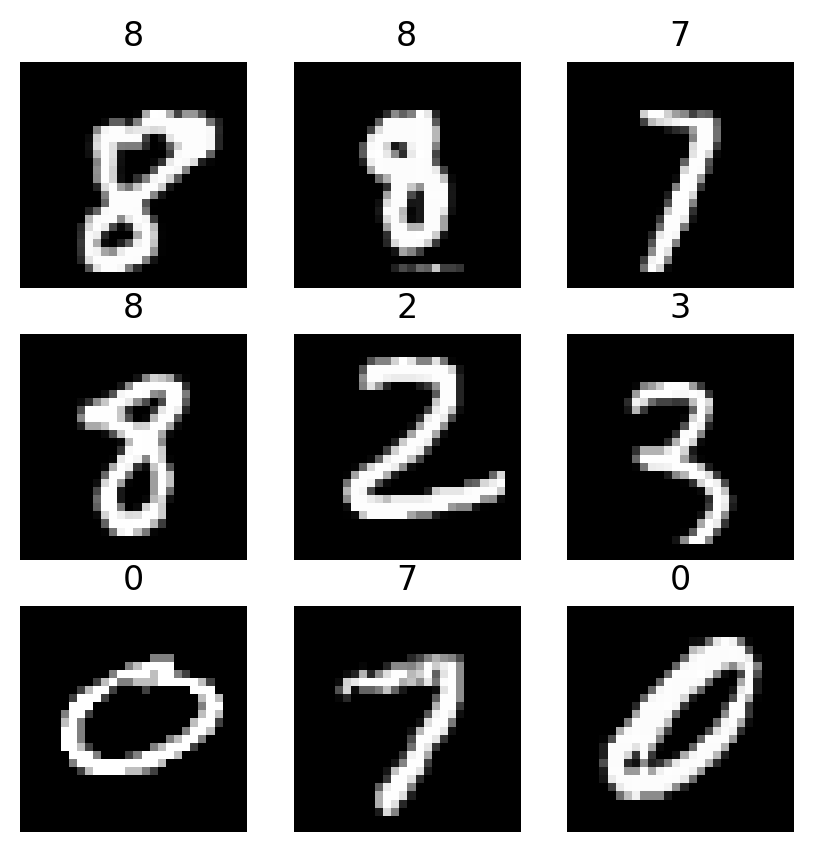

In [4]:
# Extract Training Dataset Randomly
indexes = np.random.randint(0, x_train.shape[0], size=9)
images = x_train[indexes]
labels = y_train[indexes]

# Draw 9 MNIST dataset
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(3,3, i+1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(y_train[indexes[i]])
plt.show()

## Preprocessing

In [5]:
from keras.layers import Flatten, Dense, Dropout

In [6]:
# Count the number of labels
num_labels = len(np.unique(y_train))

# One-Hot Encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Image Dimension
image_size = x_train.shape[1] # (60000, 28, 28)
input_size = (image_size, image_size)

# Normalize
x_train = x_train.astype('float32')/255 # Normalize
x_test = x_test.astype('float32')/255 # Normalize

# NN Parameters
batch_size = 128
hidden_units = 256
dropout = .45

## Modeling
- Build-up Sequential API Model
- Layers: 256-256-256
- Regularizer: Dropdout(.45)
- Optimizer: Adam

In [7]:
def create_seq_model():
    model = keras.Sequential()
    model.add(Flatten(input_shape = input_size))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_labels, activation='softmax'))
    return model

seq_model = create_seq_model()
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 269322 

2023-06-13 17:34:00.272718: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-13 17:34:00.272787: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-06-13 17:34:00.272802: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-06-13 17:34:00.272880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 17:34:00.272930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def create_func_model():
    inputs = keras.Input(shape = input_size)
    flatten = keras.layers.Flatten()(inputs)
    dense1 = keras.layers.Dense(hidden_units, activation='relu')(flatten)
    drop1 = keras.layers.Dropout(dropout)(dense1)
    dense2 = keras.layers.Dense(hidden_units, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(dropout)(dense2)
    outputs = keras.layers.Dense(num_labels, activation='softmax')(drop2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

func_model = create_func_model()
func_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570  

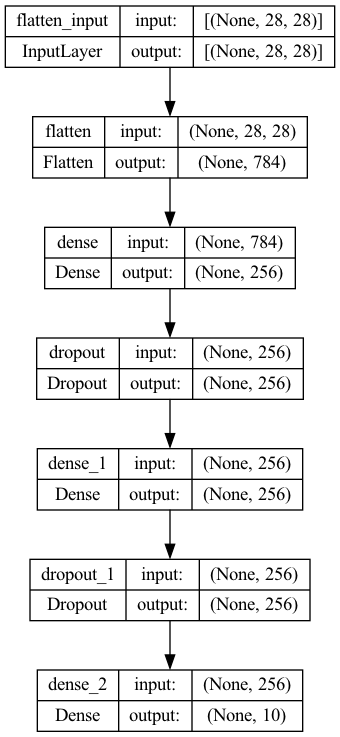

In [9]:
keras.utils.plot_model(seq_model, to_file='MNIST_MLP.png', show_shapes=True)

In [10]:
learning_rate=0.001
seq_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy']
                 )

In [11]:
history = seq_model.fit(x_train, y_train,
                        epochs=20,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test))

Epoch 1/20
  8/469 [..............................] - ETA: 3s - loss: 2.1552 - accuracy: 0.2451  

2023-06-13 17:34:04.415834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.8278

2023-06-13 17:34:07.969270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 4s 8ms/step - loss: 0.6016 - accuracy: 0.8278 - val_loss: 0.3598 - val_accuracy: 0.9104
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 1.0020 - accuracy: 0.8251 - val_loss: 0.6485 - val_accuracy: 0.9034
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 2.2536 - accuracy: 0.7982 - val_loss: 1.3094 - val_accuracy: 0.8936
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 4.1665 - accuracy: 0.7857 - val_loss: 2.8180 - val_accuracy: 0.8628
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 6.7567 - accuracy: 0.7803 - val_loss: 4.5157 - val_accuracy: 0.8556
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 10.3556 - accuracy: 0.7718 - val_loss: 6.5700 - val_accuracy: 0.8527
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 13.7585 - accuracy: 0.7752 - val_loss: 6.6257 - val_accuracy: 0.8736
Epoch 8/20
469/

In [12]:
loss, acc = seq_model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"Test accuracy: {(100*acc):>.1f}%")

79/79 [==============================] - 0s 6ms/step - loss: 53.1590 - accuracy: 0.8462
Test accuracy: 84.6%


## Visualization

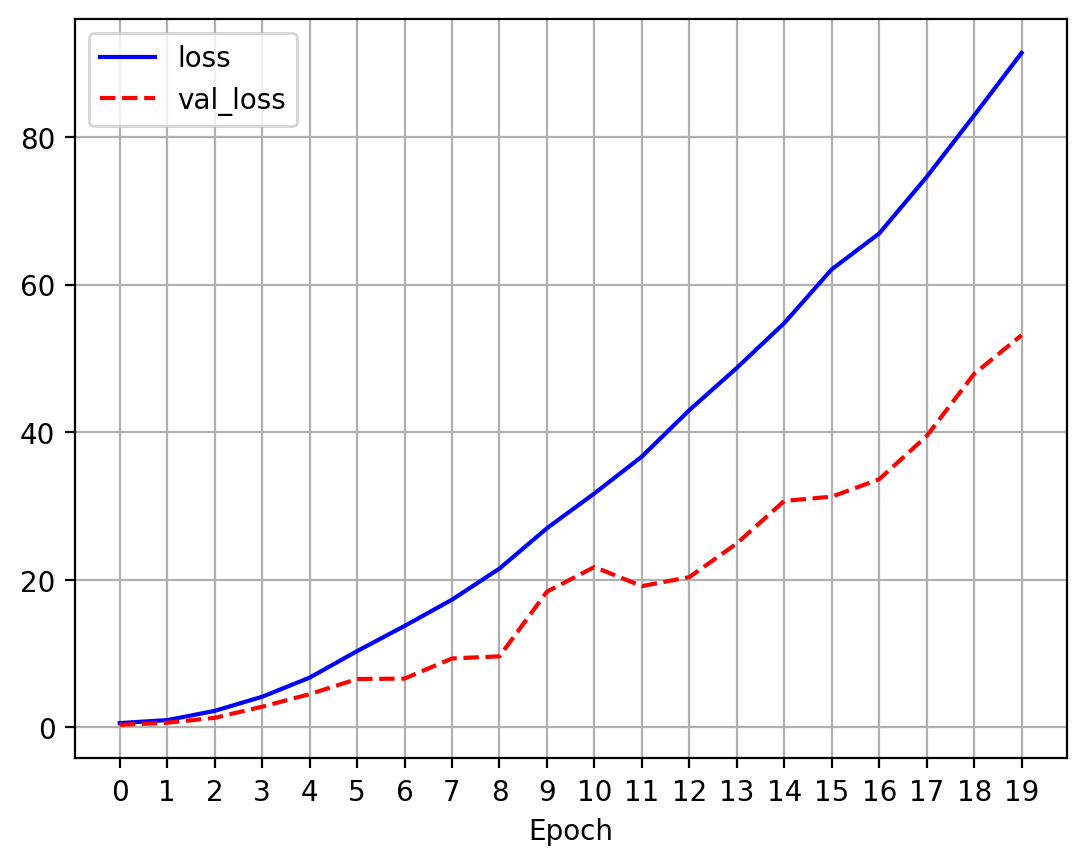

In [13]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.xticks(range(0,20))
plt.grid()
plt.legend()
plt.show()

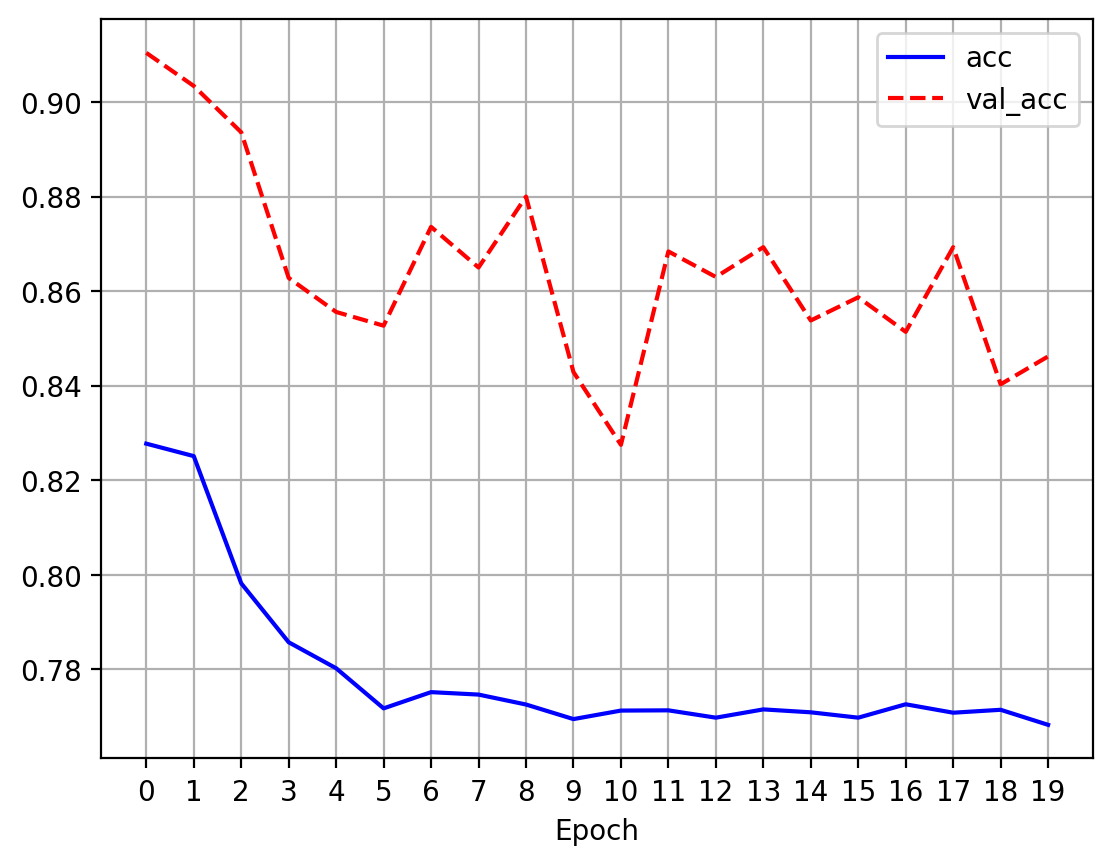

In [14]:
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.xticks(range(20))
plt.grid()
plt.legend()
plt.show()

## Tensorboard

In [15]:
%load_ext tensorboard

In [16]:
new_model_1 = create_func_model()
new_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                   )

In [17]:
new_model_1.evaluate(x_test, y_test)

 11/313 [>.............................] - ETA: 1s - loss: 2.3234 - accuracy: 0.1989 

2023-06-13 17:35:18.168082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 2.3833 - accuracy: 0.1729


[2.3833227157592773, 0.1729000061750412]

In [18]:
log_dir = './log/MNIST_MLP'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
# histogram_freq=1 : save per 1 epoch; Distribution about the weight and bias

In [19]:
new_model_1.fit(x_train, y_train,
                epochs=20,
                batch_size=batch_size,
                validation_data=(x_test, y_test),
                callbacks=[tensorboard_cb]
               )

Epoch 1/20
  8/469 [..............................] - ETA: 3s - loss: 2.0927 - accuracy: 0.2783  

2023-06-13 17:35:20.115584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 4s 8ms/step - loss: 0.6080 - accuracy: 0.8259 - val_loss: 0.3833 - val_accuracy: 0.9070
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.9832 - accuracy: 0.8265 - val_loss: 0.7437 - val_accuracy: 0.8831
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 2.2684 - accuracy: 0.7977 - val_loss: 1.4348 - val_accuracy: 0.8875
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 3.9584 - accuracy: 0.7904 - val_loss: 2.9268 - val_accuracy: 0.8538
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 6.1069 - accuracy: 0.7860 - val_loss: 3.8812 - val_accuracy: 0.8693
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 8.6785 - accuracy: 0.7877 - val_loss: 4.9167 - val_accuracy: 0.8621
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 10.8333 - accuracy: 0.7872 - val_loss: 8.7551 - val_accuracy: 0.8368
Epoch 8/20
469/4

In [20]:
%tensorboard --logdir $log_dir

## Save and Load

In [21]:
# Save Parameters
seq_model.save_weights('./save/seq_model.skpt')

In [22]:
# Create New model
seq_model_2 = create_func_model()
seq_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                   )

In [23]:
seq_model_2.evaluate(x_test, y_test)

  1/313 [..............................] - ETA: 39s - loss: 2.6700 - accuracy: 0.0938

2023-06-13 17:36:37.085931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.5542 - accuracy: 0.0859


[2.554171085357666, 0.08590000122785568]

In [24]:
seq_model_2.load_weights('./save/seq_model.skpt')

In [25]:
seq_model_2.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 53.1590 - accuracy: 0.8462


[53.159019470214844, 0.8461999893188477]

In [26]:
# Save Whole model information
seq_model.save('./save/seq_model')

INFO:tensorflow:Assets written to: ./save/seq_model/assets


INFO:tensorflow:Assets written to: ./save/seq_model/assets


In [27]:
# Create New model
seq_model_3 = create_func_model()
seq_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'],
                   )

In [ ]:
seq_model_3.evaluate(x_test, y_test)

 10/313 [..............................] - ETA: 1s - loss: 2.4285 - accuracy: 0.1156 

2023-06-13 17:36:41.256033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 29/313 [=>............................] - ETA: 1s - loss: 2.4282 - accuracy: 0.1121

In [ ]:
seq_model_3 = keras.models.load_model('./save/seq_model')

In [ ]:
seq_model_3.evaluate(x_test, y_test)